In [2]:
%pip install torch torchvision matplotlib concrete concrete-ml
%pip install onnx

Traceback (most recent call last):
  File "/home/mango/.local/bin/thefuck", line 5, in <module>
    from thefuck.entrypoints.main import main
  File "/home/mango/.local/lib/python3.12/site-packages/thefuck/entrypoints/main.py", line 8, in <module>
    from .. import logs  # noqa: E402
    ^^^^^^^^^^^^^^^^^^^
  File "/home/mango/.local/lib/python3.12/site-packages/thefuck/logs.py", line 8, in <module>
    from .conf import settings
  File "/home/mango/.local/lib/python3.12/site-packages/thefuck/conf.py", line 1, in <module>
    from imp import load_source
ModuleNotFoundError: No module named 'imp'
Traceback (most recent call last):
  File "/home/mango/.local/bin/thefuck", line 5, in <module>
    from thefuck.entrypoints.main import main
  File "/home/mango/.local/lib/python3.12/site-packages/thefuck/entrypoints/main.py", line 8, in <module>
    from .. import logs  # noqa: E402
    ^^^^^^^^^^^^^^^^^^^
  File "/home/mango/.local/lib/python3.12/site-packages/thefuck/logs.py", line 8, in <

In [5]:
import time
import torch
#import torchvision
#import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

# Utility to measure time
def measure_time(func):
    start_time = time.time()
    result = func()
    elapsed_time = time.time() - start_time
    return result, elapsed_time

# Utility to check for convergence
def has_converged(train_acc, val_acc, threshold=0.01):
    return abs(train_acc - val_acc) <= threshold

def denormalize(tensor, mean, std):
    tensor = tensor.clone()  # Avoid modifying the original tensor
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  # Reverse the normalization
    return tensor

"""def show_test_images_with_predictions(model, test_loader):
    device = next(model.parameters()).device
    model.eval()
    images, labels = next(iter(test_loader))
    outputs = model(images.to(device))
    _, preds = torch.max(outputs, 1)

    plt.figure(figsize=(10, 10))
    for i in range(6):  # Show 6 images
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))  # Convert from tensor to image format
        plt.title(f'Pred: {preds[i].item()}, True: {labels[i].item()}')
        plt.axis('off')
    plt.show() """

def show_test_images_with_predictions(model, test_loader, device):
    model.eval()
    images, labels = next(iter(test_loader))
    images = images.to(device)
    
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    # Move images to CPU for visualization and denormalize them
    images = images.cpu()

    # Denormalize (undo the normalization applied during preprocessing)
    mean = [0.5, 0.5, 0.5]  # For each of the 3 channels
    std = [0.5, 0.5, 0.5]
    images = denormalize(images, mean, std)

    plt.figure(figsize=(10, 10))
    for i in range(6):  # Show 6 images
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))  # Convert from tensor to image format
        plt.title(f'Pred: {preds[i].item()}, True: {labels[i].item()}')
        plt.axis('off')
    plt.show()

In [4]:
from torchvision.transforms import Lambda

# CIFAR-10 dataset
def get_cifar10_loaders(batch_size=32):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

# MNIST dataset
def get_mnist_loaders(batch_size=32):
    transform = transforms.Compose([
        transforms.Resize((32, 32)),  # Resize MNIST images to 32x32 (to match CIFAR-10 size)
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
        Lambda(lambda x: x.repeat(3, 1, 1))  # Convert 1-channel grayscale to 3 channels
    ])
    
    train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

In [6]:
# Define the CNN model with convolutional layers for CIFAR-10
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64*8*8, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 classes for CIFAR-10

        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.max_pool(self.relu(self.conv1(x)))
        x = self.max_pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        #x = x.view(-1, 64*8*8)  # Flatten the feature map for the fully connected layer
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [7]:
def train_until_convergence(model, train_loader, test_loader, optimizer, criterion, device, patience=5):
    model.to(device)
    train_acc_history, val_acc_history, train_loss_history = [], [], []
    no_improvement_count = 0

    for epoch in range(10):  # We allow up to 100 epochs, but we'll stop early
        model.train()
        correct_train, total_train = 0, 0
        running_loss = 0.0

        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)

        # Validation loop
        model.eval()
        correct_val, total_val = 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_acc = 100 * correct_val / total_val
        val_acc_history.append(val_acc)

        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')

        # Check for convergence
        #if has_converged(train_acc, val_acc):
        #    print(f'Convergence reached at epoch {epoch+1}!')
        #    break

        # Early stopping if there's no improvement
        if len(val_acc_history) > 1 and val_acc_history[-1] <= val_acc_history[-2]:
            no_improvement_count += 1
            if no_improvement_count >= patience:
                print(f'Early stopping at epoch {epoch+1} due to no improvement.')
                break
        else:
            no_improvement_count = 0

    return train_acc_history, val_acc_history, train_loss_history, model


In [8]:
def execute_training(device_name="cpu"):
    device = torch.device(device_name)

    # Model, optimizer, and loss function
    model = SimpleCNN()  # Or SimpleCNN if using the model defined earlier for MNIST/CIFAR10
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Get data loaders
    train_loader, test_loader = get_cifar10_loaders()

    # Train the model
    def train_func():
        return train_until_convergence(model, train_loader, test_loader, optimizer, criterion, device)

    result, elapsed_time = measure_time(train_func)
    train_acc_history, val_acc_history, train_loss_history, model = result

    print(f'Training on {device_name.upper()} took {elapsed_time:.2f} seconds.')
    return train_acc_history, val_acc_history, elapsed_time, model


In [8]:
# Run on GPU if available
if torch.cuda.is_available():
    gpu_results = execute_training("cuda")
    
# Run on CPU
cpu_results = execute_training("cpu")

# Save results and plot


100%|██████████| 170498071/170498071 [00:09<00:00, 17098018.88it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch 1: Train Loss: 1.2825, Train Acc: 53.74%, Val Acc: 64.46%
Epoch 2: Train Loss: 0.9162, Train Acc: 67.53%, Val Acc: 68.89%
Epoch 3: Train Loss: 0.7620, Train Acc: 72.96%, Val Acc: 70.49%
Epoch 4: Train Loss: 0.6478, Train Acc: 77.34%, Val Acc: 71.83%
Epoch 5: Train Loss: 0.5496, Train Acc: 80.71%, Val Acc: 71.48%
Epoch 6: Train Loss: 0.4615, Train Acc: 83.76%, Val Acc: 72.12%
Epoch 7: Train Loss: 0.3804, Train Acc: 86.60%, Val Acc: 72.41%
Epoch 8: Train Loss: 0.3082, Train Acc: 88.98%, Val Acc: 71.46%
Epoch 9: Train Loss: 0.2495, Train Acc: 91.10%, Val Acc: 71.35%
Epoch 10: Train Loss: 0.2042, Train Acc: 92.73%, Val Acc: 70.73%
Training on CUDA took 174.68 seconds.
Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train Loss: 1.2771, Train Acc: 54.22%, Val Acc: 64.13%
Epoch 2: Train Loss: 0.9085, Train Acc: 67.96%, Val Acc: 67.27%
Epoch 3: Train Loss: 0.7545,

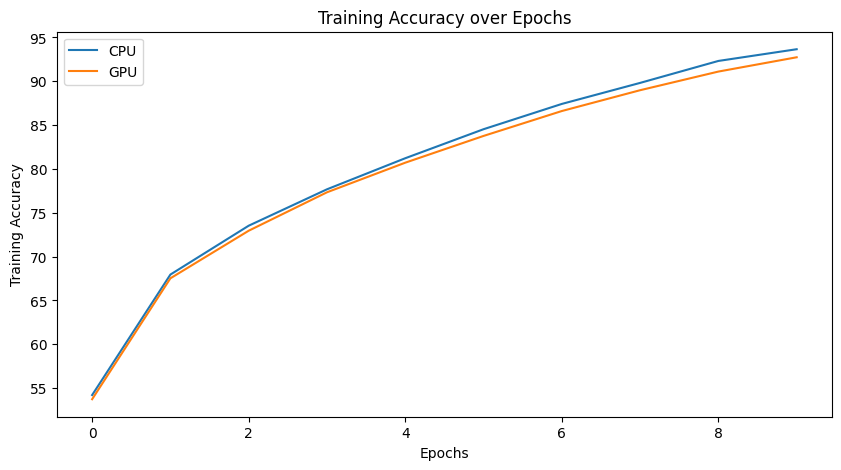

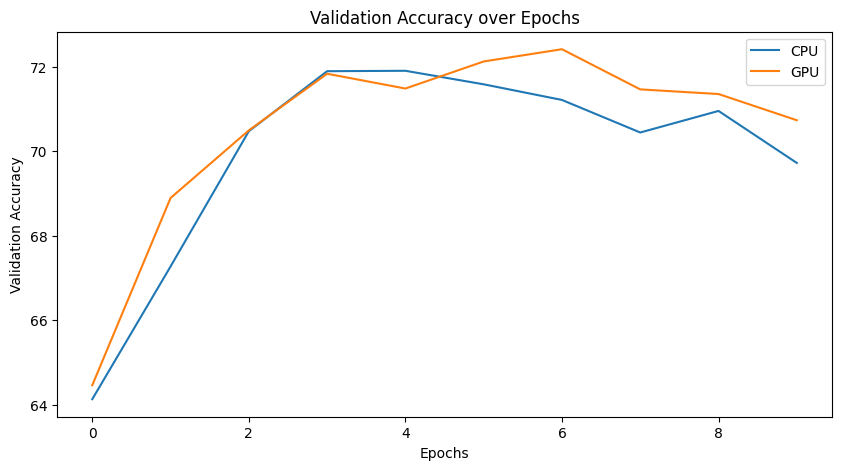

In [9]:
# Example function to plot training and validation accuracy
def plot_results(cpu_history, gpu_history, metric_name):
    plt.figure(figsize=(10, 5))
    
    plt.plot(cpu_history, label='CPU')
    if gpu_history:
        plt.plot(gpu_history, label='GPU')
    
    plt.title(f'{metric_name} over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()
    plt.show()

# Plot training accuracy and validation accuracy
plot_results(cpu_results[0], gpu_results[0], 'Training Accuracy')
plot_results(cpu_results[1], gpu_results[1], 'Validation Accuracy')


Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9372549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7411765..0.8352941].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..0.7254902].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.654902].


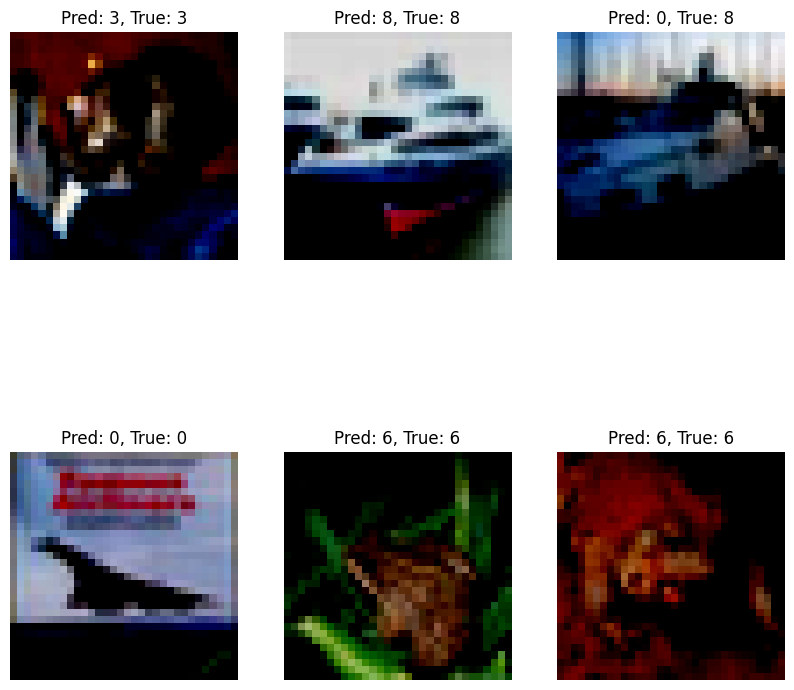

In [10]:
train_loader, test_loader = get_cifar10_loaders()

show_test_images_with_predictions(cpu_results[-1], test_loader)


In [17]:
cpu_model = cpu_results[-1]
torch.save(cpu_model.state_dict(), 'models/simple_cnn_cifar.pth')

gpu_model = gpu_results[-1]
torch.save(gpu_model.state_dict(), 'models/simple_cnn_cifar_gpu.pth')

In [8]:
# MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_set_mnist = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set_mnist = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader_mnist = DataLoader(train_set_mnist, batch_size=32, shuffle=True)
test_loader_mnist = DataLoader(test_set_mnist, batch_size=32, shuffle=False)


In [10]:
from peft import LoraConfig, get_peft_model

# Define LoRA configuration
lora_config = LoraConfig(
    r=1, lora_alpha=1, lora_dropout=0.01, 
    target_modules=["conv1", "conv2", "fc1", "fc2"],  # Apply LoRA to both conv and linear layers
    bias="none"
)

def load_pretrained_model(device_name="cpu"):
    # Load the pre-trained model from file based on device
    if device_name == "cpu":
        model_path = 'models/simple_cnn_cifar.pth'
    elif device_name == "cuda":
        model_path = 'models/simple_cnn_cifar_gpu.pth'
    else:
        raise ValueError("Unsupported device name.")
    
    # Define the model architecture (must match the saved model architecture)
    model = SimpleCNN()
    model.load_state_dict(torch.load(model_path, map_location=device_name))
    
    return model


device = "cpu"
model = load_pretrained_model(device)
model.to(device)
    
# Apply LoRA to the loaded CIFAR-10 model
peft_model = get_peft_model(model, lora_config)


/home/mango/Documents/GitHub/FHE-experiments/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_30624/2991601764.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommen

In [ ]:
from concrete.ml.torch.lora import LoraTraining, get_remote_names
from concrete.ml.torch.hybrid_model import HybridFHEModel

# Prepare LoRA training
lora_training = LoraTraining(peft_model)

# Configure training parameters
lora_training.update_training_parameters(
    optimizer=optim.Adam(filter(lambda p: p.requires_grad, peft_model.parameters()), lr=0.01),
    loss_fn=nn.CrossEntropyLoss(),
    training_args={"gradient_accumulation_steps": 1}
)

# Identify layers that can be outsourced for FHE
remote_names = get_remote_names(lora_training)

# Build a hybrid FHE model to handle encrypted computation
hybrid_model = HybridFHEModel(lora_training, module_names=remote_names)


In [9]:
# Representative dataset for calibration (use small batch)
train_loader_cifar, test_loader_cifar = get_cifar10_loaders()

# Sample input for calibration
for images, labels in train_loader_cifar:
    inputset = (images[:16], labels[:16])
    break

# Calibrate and compile the hybrid model
hybrid_model.model.toggle_calibrate(enable=True)
hybrid_model.compile_model(inputset, n_bits=8)
hybrid_model.model.toggle_calibrate(enable=False)


Files already downloaded and verified
Files already downloaded and verified


In [10]:
# Fine-tune the model on the MNIST dataset
train_loader_mnist, test_loader_mnist = get_mnist_loaders(batch_size=64)#2048)

# Fine-tune on MNIST and measure time
def fine_tune_mnist():
    max_iterations = 1
    hybrid_model.model.inference_model.train()
    hybrid_model.model.toggle_run_optimizer(enable=True)
    
    iteration = 0
    for images, labels in train_loader_mnist:
        loss, _ = hybrid_model((images, labels), fhe="execute")
        print(f"Fine-tuning Loss: {loss.item()}")
        iteration += 1
        if iteration >= max_iterations:
            break

_, finetune_time = measure_time(fine_tune_mnist)
print(f'Fine-tuning on {device.upper()} took {finetune_time:.2f} seconds.')


Fine-tuning Loss: 23.16499137878418
Fine-tuning on CPU took 77.30 seconds.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].


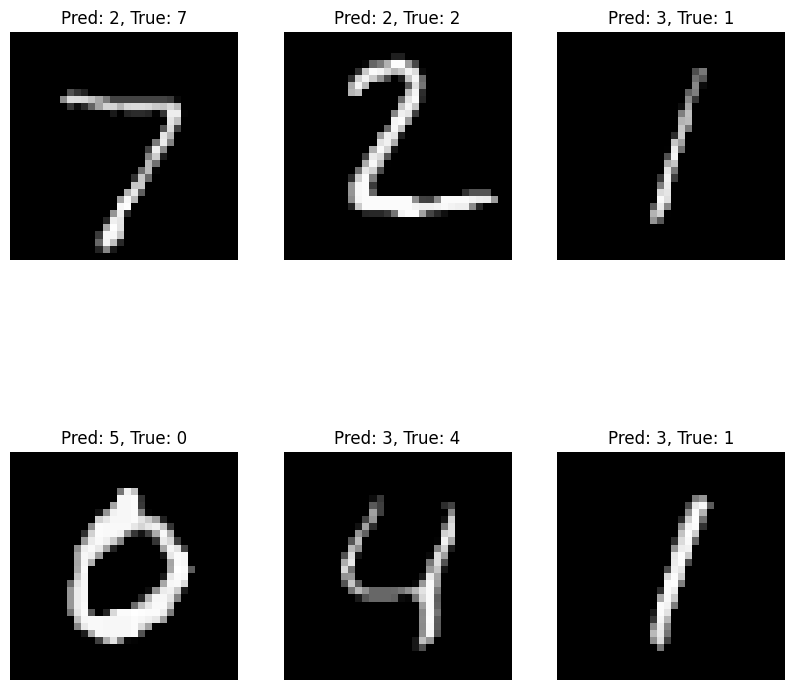

Inference without LoRA:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].


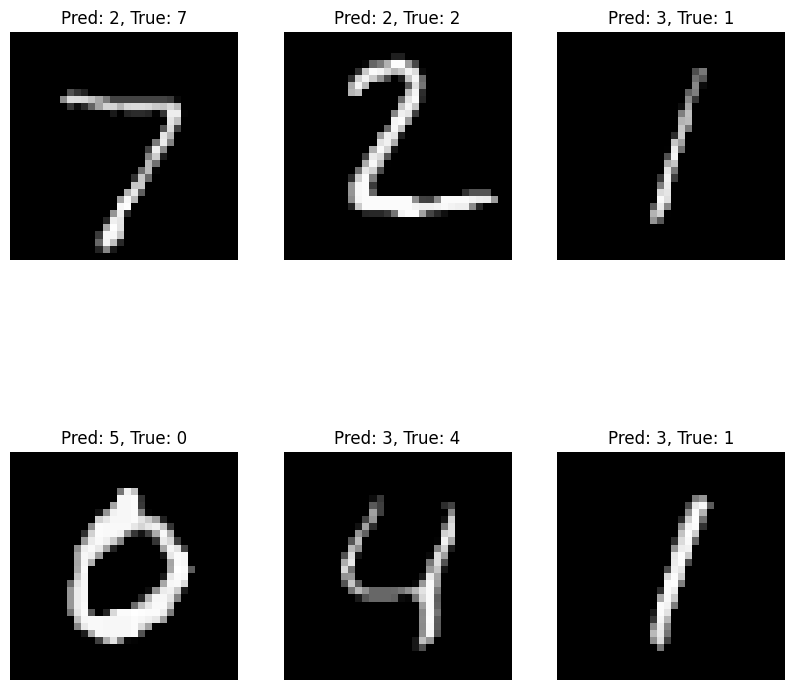

Inference with LoRA:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].


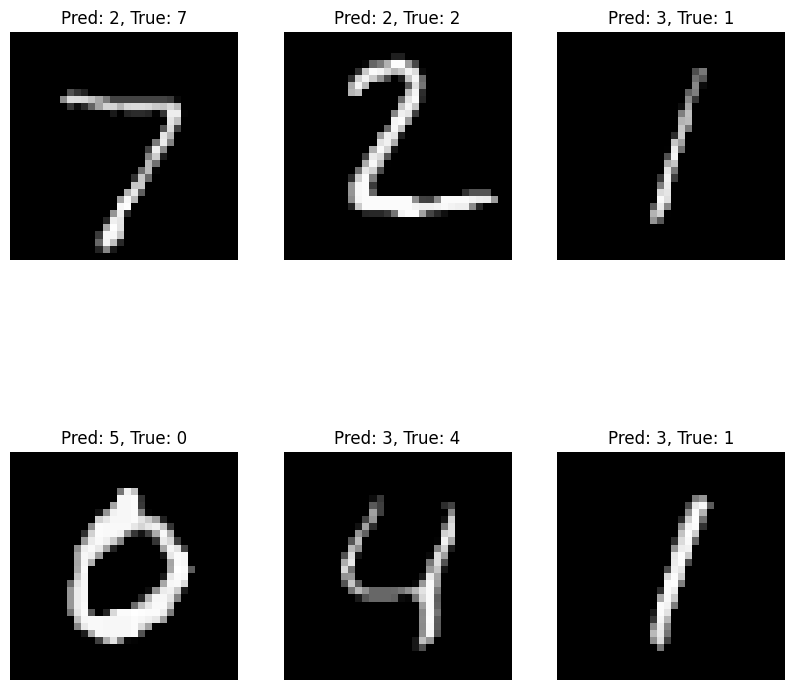

In [13]:
# Perform inference with the fine-tuned model on test data
hybrid_model.model.inference_model.eval()

# Show predictions on test data
show_test_images_with_predictions(hybrid_model.model.inference_model, test_loader_mnist)

# Disable LoRA adapters and perform inference
hybrid_model.model.inference_model.disable_adapter_layers()
print("Inference without LoRA:")
show_test_images_with_predictions(hybrid_model.model.inference_model, test_loader_mnist)

# Re-enable LoRA adapters and perform inference
hybrid_model.model.inference_model.enable_adapter_layers()
print("Inference with LoRA:")
show_test_images_with_predictions(hybrid_model.model.inference_model, test_loader_mnist)


In [1]:
# Perform inference on test data
peft_model.eval()
correct = 0
total = 0
with torch.no_grad():
    max_iterations = 1
    iteration = 0
    for images, labels in test_loader_mnist:
        iteration += 1
        images, labels = images.to(device), labels.to(device)
        outputs = peft_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if iteration >= max_iterations:
            break

print(f'Accuracy: {100 * correct / total}%')



Accuracy: 9.375%%


(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)


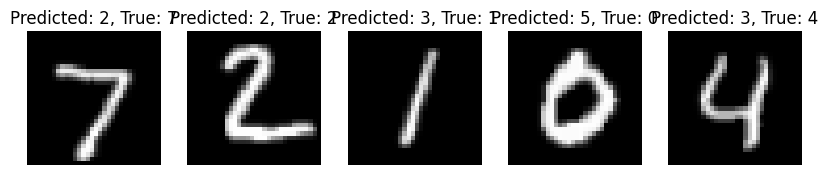

In [16]:
# Display a few test images with predictions
def show_predictions(model, loader, num_images=5):
    model.eval()
    images, labels = next(iter(loader))
    outputs = model(images.to(device))
    _, preds = torch.max(outputs, 1)
    
    images = images.cpu().numpy()
    
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        print(images[i].shape)
        plt.imshow(images[i][0].squeeze(), cmap='gray')
        plt.title(f'Predicted: {preds[i].item()}, True: {labels[i].item()}')
        plt.axis('off')
    plt.show()

# Show predictions
show_predictions(peft_model, test_loader_mnist)


In [17]:
torch.save(peft_model.state_dict(), './models/perf_model_mnist.pth')


# ONNX Conversion

In [9]:
import torch
import torch.onnx

# Load the pre-trained model (assuming it's already trained and saved)
model = SimpleCNN()
model.load_state_dict(torch.load('models/simple_cnn_cifar.pth'))  # Load the CPU-trained model
model.eval()  # Set the model to evaluation mode

# Example dummy input (adjust based on your input size)
dummy_input = torch.randn(1, 3, 32, 32)  # Assuming input is 3 channels, 32x32 as for CIFAR-10

# Export the model to ONNX with dynamic axes for batch size
onnx_file_path = "simple_cnn_cifar.onnx"
torch.onnx.export(
    model, dummy_input, onnx_file_path, 
    input_names=['input'], output_names=['output'],
    opset_version=14,
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}  # For dynamic batch dimension
)

print(f"Model successfully exported to {onnx_file_path}")



Model successfully exported to simple_cnn_cifar.onnx


In [10]:
import numpy as np
import onnx
from concrete.ml.torch.compile import compile_onnx_model

# Load the ONNX model
onnx_model = onnx.load(onnx_file_path)
onnx.checker.check_model(onnx_model)  # Optional: Check if the model is well-formed

# Create a random input set for PTQ (Post-Training Quantization)
n_examples = 50
input_shape = (3, 32, 32)  # Same input shape as CIFAR-10
input_set = np.random.uniform(-1, 1, size=(n_examples, *input_shape))

# Compile the ONNX model using Concrete ML with PTQ
n_bits = 3  # Define the number of bits for quantization
quantized_module = compile_onnx_model(onnx_model, input_set, n_bits=n_bits)

print("Model successfully compiled using PTQ.")


AssertionError: 

In [11]:
import torch.onnx
import onnx
from concrete.ml.torch.compile import compile_onnx_model

onnx_file_path = "simple_model.onnx"
torch.onnx.export(
    model,
    dummy_input,
    onnx_file_path,
    input_names=['input'],
    output_names=['output'],
    opset_version=14
)

print(f"Model exported to {onnx_file_path}")

onnx_model = onnx.load(onnx_file_path)

# Check the operators used in the ONNX model
operator_set = set()
for node in onnx_model.graph.node:
    operator_set.add(node.op_type)
print("Operators used:", operator_set)

n_bits_qat = 3

quantized_numpy_module = compile_onnx_model(
    onnx_model,
    dummy_input,
    import_qat=False,  # Set import_qat to False
    n_bits=n_bits_qat,
)


Model exported to simple_model.onnx
Operators used: {'Relu', 'MaxPool', 'Reshape', 'Conv', 'Constant', 'Gemm'}


In [ ]:
# Create test data from the same distribution for inference
test_input = np.random.uniform(-1, 1, size=(1, *input_shape))

# Run inference in clear mode
t1 = time.time()
y_clear = quantized_numpy_module.forward(test_input, fhe="disable")
t2 = time.time()

# Run inference in FHE mode
y_fhe = quantized_numpy_module.forward(test_input, fhe="execute")
t3 = time.time()

# Compare results
print("Execution in clear: ", y_clear)
print("Execution in FHE:   ", y_fhe)
print("Equality:           ", np.allclose(y_clear, y_fhe))
print("Time in clear:      ", t2 - t1)
print("Time in FHE:        ", t3 - t2)


## Exporting model structure for debugging

In [10]:
import torch
import torch.onnx

# Load the pre-trained model (assuming it's already trained and saved)
model = SimpleCNN()
model.load_state_dict(torch.load('models/simple_cnn_cifar.pth'))  # Load the CPU-trained model
model.eval()  # Set the model to evaluation mode

# Example dummy input (adjust based on your input size)
dummy_input = torch.randn(1, 3, 32, 32)  # Assuming input is 3 channels, 32x32 as for CIFAR-10

# Export the model to ONNX with dynamic axes
onnx_file_path = "simple_cnn_cifar.onnx"
torch.onnx.export(
    model, dummy_input, onnx_file_path, 
    input_names=['input'], output_names=['output'],
    opset_version=14,  # Adjust opset version if needed
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}  # For batch dimension
)

print(f"Model successfully exported to {onnx_file_path}")


Model successfully exported to simple_cnn_cifar.onnx


In [24]:
import onnx
from onnx import shape_inference

# Load the ONNX model
onnx_model = onnx.load(onnx_file_path)

# Perform shape inference
onnx_model_inferred = shape_inference.infer_shapes(onnx_model)

# Save the inferred model to inspect it further
onnx.save(onnx_model_inferred, "simple_cnn_cifar_inferred.onnx")

# You can now open 'simple_cnn_cifar_inferred.onnx' in Netron to inspect the shapes
